In [8]:
import torch
import torch.nn as nn
from torchvision import models

device = 'cuda' 

resnet50 = models.resnet50(pretrained=True)

for param in resnet50.parameters():
    param.requires_grad = False

num_features = resnet50.fc.in_features 
resnet50.fc = nn.Linear(num_features, 7) 
resnet50.to(device)

for param in resnet50.fc.parameters():
    param.requires_grad = True

c:\Users\adity\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\adity\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Creating the DataLoader

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import pandas as pd
from PIL import Image

# Load and prepare the dataset
data = pd.read_csv('HAM10000_metadata_paths.csv')
data['image_path'] = data['image_path'].str.replace('\\', '/')
mapping = {'bkl': 0, 'nv': 1, 'df': 2, 'mel': 3, 'bcc': 4, 'akiec': 5, 'vasc': 6}
X = data['image_path']
y = data['dx'].map(mapping)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

class HAM(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X.reset_index(drop=True)
        self.y = y.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img_path = self.X[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.y[idx]
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label)
        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = HAM(X_train, y_train, transform=transform)
val_dataset = HAM(X_val, y_val, transform=transform)
test_dataset = HAM(X_test, y_test, transform=transform)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
optimizer = torch.optim.Adam(resnet50.fc.parameters(), lr=0.005)
loss_fn = nn.CrossEntropyLoss()
device = 'cuda'
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
loss_fn = nn.CrossEntropyLoss()

def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=50, device='cuda'):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(epochs):
        print(f'Epoch: {epoch}')
        model.train()
        train_loss, correct = 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

        train_loss /= len(train_loader)
        train_accuracy = correct / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss, correct = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = correct / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    torch.save(model.state_dict(), 'resnet50_model.pth')
    return train_losses, train_accuracies, val_losses, val_accuracies

In [11]:
train_losses, train_accuracies, val_losses, val_accuracies = train(resnet50, optimizer, loss_fn, train_loader, val_loader, epochs=3, device='cuda')
print(f'Training Losses: {train_losses}')
print(f'Training Accuracies: {train_accuracies}')
print(f'Validation Losses: {val_losses}')
print(f'Validation Accuracies: {val_accuracies}')

Epoch 1: Train Loss: 0.9721, Train Accuracy: 0.7047, Val Loss: 0.7999, Val Accuracy: 0.7063
Epoch 2: Train Loss: 0.7446, Train Accuracy: 0.7463, Val Loss: 0.8276, Val Accuracy: 0.7393
Epoch 3: Train Loss: 0.6723, Train Accuracy: 0.7641, Val Loss: 0.7162, Val Accuracy: 0.7463
Training Losses: [0.9721133155482156, 0.7446135280151216, 0.672278638160418]
Training Accuracies: [0.7046929605591613, 0.7462556165751373, 0.7641038442336495]
Validation Losses: [0.7998504787683487, 0.8276484161615372, 0.7162384614348412]
Validation Accuracies: [0.7062937062937062, 0.7392607392607392, 0.7462537462537463]


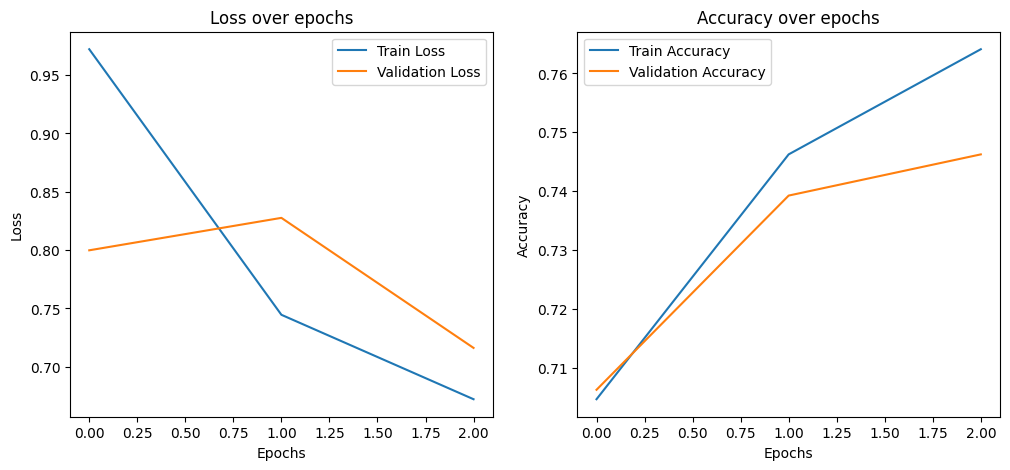

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [13]:
resnet50.eval()
test_loss, correct, all_predictions, all_targets = 0, 0, [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet50(inputs)
        loss = loss_fn(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        all_predictions.extend(predicted.view(-1).tolist())
        all_targets.extend(labels.view(-1).tolist())
    
test_loss /= len(test_loader)
test_accuracy = correct / len(test_loader.dataset)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.7242, Test Accuracy: 0.7445
